In [30]:
import warnings
import pandas as pd
from matplotlib import pyplot as plt
from aeon.visualisation import plot_series
from sklearn.metrics import mean_absolute_percentage_error as mape
from all_functions import *
import os
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
warnings.filterwarnings("ignore")
%matplotlib inline

In [31]:
def get_each_point_error(path, val_date):
    df = pd.read_csv(path, sep=";")
    
    df_filtered = df[df['test_range'] <= val_date].copy()

    df_filtered = df_filtered.iloc[::-1]
    
    error_series_concatenated = []
    for _, row in df_filtered.iterrows():
        error_series_str = row['error_series']
        error_list = ast.literal_eval(error_series_str)
        error_series_concatenated.append(error_list)
    return error_series_concatenated


def get_all_error_series(path, val_date):
    df = pd.read_csv(path, sep=";")
    
    df_filtered = df[df['test_range'] <= val_date].copy()

    df_filtered = df_filtered.iloc[::-1]
    
    error_series_concatenated = []
    for _, row in df_filtered.iterrows():
        error_series_str = row['error_series']
        error_list = ast.literal_eval(error_series_str)
        error_series_concatenated.extend(error_list)
    
    return error_series_concatenated

def generate_index(start_date, end_date):
    end_date_dt = pd.to_datetime(end_date)
    
    start_date_dt = pd.to_datetime(start_date)
    
    index = pd.period_range(start=start_date_dt, end=end_date_dt, freq='M')

    return index

def get_train_real(series, start_date):
    start_period = pd.to_datetime(start_date).to_period('M')
    
    filtered_series = series[series.index < start_period]

    return filtered_series

def preds_recursive_meta(example, model, horizon):
  preds = []
  for i in range(horizon):
    pred = model.predict(example)[0]
    preds.append(pred)

    example = example[:,1:]

    example = np.append(example, pred)
    example = example.reshape(1,-1)
  return preds

def get_preds_hybrid(path, test_date, start_index):
    df = pd.read_csv(path, sep=";")
    results = {}
    filtered_df = df[df['test_range'] == test_date]
    columns_p1_to_p12 = filtered_df.loc[:, 'P1':'P12']
    values_list = columns_p1_to_p12.values.flatten().tolist()     
    results = pd.Series(values_list, index=start_index)
    return results


def save_csv(nome, csv_file, uf, derivado, models, series, test, preds, horizon=12, window=12):
    y_baseline = series[-horizon*2:-horizon].values
    rmse_result = rmse(test, preds)
    mape_result = mape(test, preds)
    pocid_result = pocid(test, preds)
    pbe_result = pbe(test, preds)
    mcpm_result = mcpm(rmse_result, mape_result, pocid_result)
    mase_result = mase(test, preds, y_baseline)

    df_result = pd.DataFrame({'DATA': nome, 'UF': uf, 'PRODUCT': derivado, 'MODEL':  f"{'_'.join(models)}", 'PARAMS': str({}), 'WINDOW': window, 'HORIZON': horizon,  
                                            'RMSE': rmse_result, 'MAPE': mape_result, 'POCID': pocid_result, 'PBE': pbe_result, 'MASE': mase_result,
                                            'P1': preds[0], 'P2': preds[1], 'P3': preds[2], 'P4': preds[3], 'P5': preds[4],
                                            'P6': preds[5], 'P7': preds[6], 'P8': preds[7], 'P9': preds[8], 'P10': preds[9],
                                            'P11': preds[10], 'P12': preds[11]
                                            }, index=[0])
    df_result.to_csv(csv_file, sep=';', mode='a', header=False, index=False)


In [32]:
def inverse_tranformation(train, serie_target, window, format="normal"):
    if format == 'deseasonal':
        transform = ConditionalDeseasonalizer(sp=12)
        transform = Deseasonalizer(sp=12)
        transform.fit(train)
        series_before_norm = transform.transform(train)

        mean = np.mean(series_before_norm.iloc[-window:])
        std = np.std(series_before_norm.iloc[-window:])

        preds_transformed = znorm_reverse(serie_target, mean, std)

        series_real = transform.inverse_transform(preds_transformed)
        return series_real
    elif format == 'log':
        constante = 10
        series_before_norm = np.log(train)
        mean = np.mean(series_before_norm.iloc[-window:])
        std = np.std(series_before_norm.iloc[-window:])
        preds_transformed = znorm_reverse(serie_target, mean, std)

        return np.exp(preds_transformed) - constante
    elif format == 'normal':
        mean = np.mean(train.iloc[-window:])
        std = np.std(train.iloc[-window:])
        preds_real = znorm_reverse(serie_target, mean, std)
        return preds_real
    
    raise ValueError('nao existe essa transformacao')

def recursive_2(X_test, train_completo, model, horizon, window, transform, representation, wavelet, level):
  example = X_test.iloc[0].values.reshape(1,-1)
  last_window_train = train_completo[-window:].tolist()
  last_window_train_pd = train_completo[-window:]
  preds = []
  preds_real = []
  for i in range(horizon):
    pred = model.predict(example)[0]
    preds.append(pred)
    
    #normaliza a ultima janela de train original
    last_window_train_pd = znorm(last_window_train_pd)

    #pega o valor do proximo index de train para adicionar em predicao
    index_pred = last_window_train_pd.index[-1] + 1
    pred_as_pd = pd.Series([pred], index=[index_pred])
    
    #concatena a predicao normalizada no ultimo pedaco do train
    last_window_train_pd = pd.concat([last_window_train_pd, pred_as_pd])

    #remove o primeiro elemento de train normalizado
    last_window_train_pd = last_window_train_pd[1:]

    #passa a serie de train+preds para desnormalizar pegando apenas o ultimo valor concatenado (pred)
    pred_real = inverse_tranformation(train_completo, last_window_train_pd, window, format=transform)[-1]
    
    #adiciona preds real ao pedaco do train real para proximas reversoes
    index_pred_real = train_completo.index[-1] + 1
    pred_real_as_pd = pd.Series([pred_real], index=[index_pred_real])
    train_completo = pd.concat([train_completo, pred_real_as_pd])

    #adiciona a predicao em escala real na lista de preds real
    preds_real.append(pred_real)

    #pega ultima janela do train original e tira o primeiro valor para concatenar a predicao posteriormente
    last_window_train = last_window_train[1:]
    last_window_train.append(pred_real)
    

    #normalizo o ultimo pedaco do train(window) + preds
    print(last_window_train)
    last_window_train_norm = znorm(last_window_train)

    #transformo novamente para gerar novo X_test
    rep_features = transform_series(last_window_train_norm, representation, wavelet, level)
    print(len(rep_features))
    example = rep_features.reshape(1,-1)
  return preds_real


In [33]:
horizon = 12
window =12
derivado = "etanolhidratado"
estado = "SP"
transform = "deseasonal"

series = read_series(f'../datasets/venda/mensal/uf/{derivado}/mensal_{estado.lower()}_{derivado}.csv')
train, test = train_test_stats(series, horizon)

train_tf = transform_regressors(train, transform)


# my_data = my_rolling_window(pd.concat([train_tf, pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=test.index)]), window)
# X_train_my, X_test_my, y_train_my, y_test_my = train_test_split(my_data, horizon)
# rg = RidgeCV(alphas=np.logspace(-3, 3, 10))
# rg.fit(X_train_my, y_train_my)

# predictions_my = recursive_my(X_test_my, train, rg, horizon, window, transform)
# preds_my = pd.Series(predictions_my, index=test.index)

In [34]:
representation = "CONCAT"
wavelet = "bior2.2"
level = 2
data_concat = rolling_window_image(pd.concat([train_tf, pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=test.index)]), window, representation, wavelet, level)                        
data_concat = data_concat.dropna()

X_train_concat, X_test_concat, y_train_concat, y_test_concat = train_test_split(data_concat, horizon)
rg = RidgeCV(alphas=np.logspace(-3, 3, 10))
rg.fit(X_train_concat, y_train_concat)

predictions_concat = recursive_2(X_test_concat, train, rg, horizon, window, transform, representation, wavelet, level)
preds_concat = pd.Series(predictions_concat, index=test.index)

#dwt
representation = "MTF"
wavelet = "bior2.2"
# transform = "normal"
level = 2

data_dwt = rolling_window_image(pd.concat([train_tf, pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=test.index)]), window, representation, wavelet, level)                        
data_dwt = data_dwt.dropna()

X_train_dwt, X_test_dwt, y_train_dwt, y_test_dwt = train_test_split(data_dwt, horizon)

rg = RidgeCV(alphas=np.logspace(-3, 3, 10))
rg.fit(X_train_dwt, y_train_dwt)

predictions_dwt = recursive_2(X_test_dwt, train, rg, horizon, window, transform, representation, wavelet, level)
preds_swt_normal = pd.Series(predictions_dwt, index=test.index)


#swt
representation = "SWT"
wavelet = "bior2.2"
# transform = "deseasonal"
level = 2

data_swt = rolling_window_image(pd.concat([train_tf, pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=test.index)]), window, representation, wavelet, level)                        
data_swt = data_swt.dropna()

X_train_swt, X_test_swt, y_train_swt, y_test_swt = train_test_split(data_swt, horizon)

rg = RidgeCV(alphas=np.logspace(-3, 3, 10))
rg.fit(X_train_swt, y_train_swt)

predictions_swt = recursive_2(X_test_swt, train, rg, horizon, window, transform, representation, wavelet, level)
preds_swt_deseasonal = pd.Series(predictions_swt, index=test.index)


#STFT
representation = "CWT"
wavelet = "bior2.2"
level = 2


data_stft = rolling_window_image(pd.concat([train_tf, pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=test.index)]), window, representation, wavelet, level)                        
data_stft = data_stft.dropna()

X_train_stft, X_test_stft, y_train_stft, y_test_stft = train_test_split(data_stft, horizon)

rg = RidgeCV(alphas=np.logspace(-3, 3, 10))
# rg = RandomForestRegressor()
rg.fit(X_train_stft, y_train_stft)

predictions_stft = recursive_2(X_test_stft, train, rg, horizon, window, transform, representation, wavelet, level)
preds_gasf_deseasonal = pd.Series(predictions_stft, index=test.index)



representation = "DWT"
# transform = "normal"
wavelet = "bior2.2"
level = 2
data_wpt = rolling_window_image(pd.concat([train_tf, pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=test.index)]), window, representation, wavelet, level)                        
data_wpt = data_wpt.dropna()

X_train_wpt, X_test_wpt, y_train_wpt, y_test_wpt = train_test_split(data_wpt, horizon)

rg = RidgeCV(alphas=np.logspace(-3, 3, 10))
rg.fit(X_train_wpt, y_train_wpt)

predictions_wpt = recursive_2(X_test_wpt, train, rg, horizon, window, transform, representation, wavelet, level)
preds_gasf_normal = pd.Series(predictions_wpt, index=test.index)

[673016.057, 632909.63, 647082.237, 697656.652, 705328.451, 742109.257, 691086.034, 640403.327, 707074.885, 567584.574, 587349.201, 600459.6338408821]
68
[632909.63, 647082.237, 697656.652, 705328.451, 742109.257, 691086.034, 640403.327, 707074.885, 567584.574, 587349.201, 600459.6338408821, 592554.5728015419]
68
[647082.237, 697656.652, 705328.451, 742109.257, 691086.034, 640403.327, 707074.885, 567584.574, 587349.201, 600459.6338408821, 592554.5728015419, 620394.4450401783]
68
[697656.652, 705328.451, 742109.257, 691086.034, 640403.327, 707074.885, 567584.574, 587349.201, 600459.6338408821, 592554.5728015419, 620394.4450401783, 614086.6942505541]
68
[705328.451, 742109.257, 691086.034, 640403.327, 707074.885, 567584.574, 587349.201, 600459.6338408821, 592554.5728015419, 620394.4450401783, 614086.6942505541, 631778.675517858]
68
[742109.257, 691086.034, 640403.327, 707074.885, 567584.574, 587349.201, 600459.6338408821, 592554.5728015419, 620394.4450401783, 614086.6942505541, 631778.67

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='m3'>)

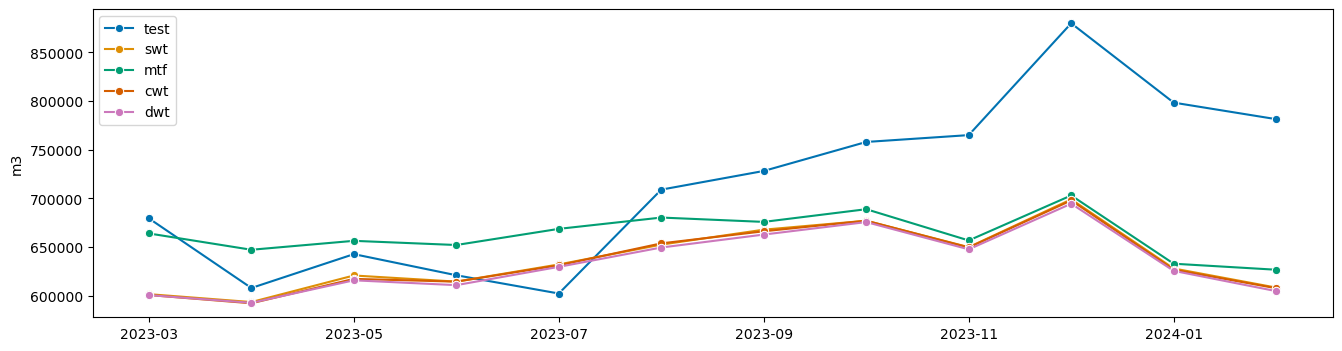

In [35]:
plot_series(test, preds_swt_deseasonal, preds_swt_normal, preds_gasf_deseasonal, preds_gasf_normal, labels=["test", "swt", "mtf","cwt", "dwt"])